In [51]:
import pandas as pd
import json
import sklearn.svm as svm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectFromModel
import numpy as np
from sklearn.neural_network import MLPClassifier
import script as sc
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
## Change the name to get your path
user = 'Hans'

## Build test and train Datasets

In [3]:
# Rebuild complete dataset if necessary
sc.update_complete(user)

C:\Users\Hans\Anaconda3\Scripts\Hans\KineseItUp\script.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  observedData['index'] = range(len(observedData))


In [4]:
data = pd.DataFrame(sc.get_complete(user))

In [5]:
data.head()

,Unnamed: 0,Unnamed: 0.1,mean.vm,sd.vm,mean.ang,sd.ang,p625,dfreq,ratio.df,start.time,index,activity,coding,type
0,0,368947,1.027036,0.065807,-32.179828,8.090852,0.188766,4.102564,0.126940,2017-10-06 16:44:06,0,active,non-sedentary,H-1
1,1,368948,1.029727,0.136367,-32.955579,8.908046,0.222211,3.076923,0.174922,2017-10-06 16:44:07,1,active,non-sedentary,H-1
2,2,368949,1.003435,0.056664,-47.568056,6.244429,0.235925,3.076923,0.245706,2017-10-06 16:44:08,2,active,non-sedentary,H-1
3,3,368950,1.020198,0.070674,-54.486552,4.062847,0.479812,2.051282,0.241239,2017-10-06 16:44:09,3,active,non-sedentary,H-1
4,4,368951,1.003209,0.031647,-52.630436,2.084940,0.443848,2.051282,0.291673,2017-10-06 16:44:10,4,active,non-sedentary,H-1


## Testing Split by Person
We will take 70% of the people.  They will be the training set. The other 30% become the testing set, whereas we will continue measuring success but with completely independent training and testing sets.

In [16]:
np.unique(data['type'])

array(['A-4', 'A-6', 'A-8', 'E-14', 'E-6', 'E-7', 'E-8', 'H-1', 'H-3',
       'H-7', 'L-1', 'L-3', 'L-5', 'W-13', 'W-4', 'W-9'], dtype=object)

In [22]:
## getting the five people to train
test_ppl = np.array(['A-6','E-6','H-1','L-5','W-9'])

x_vars = ['mean.vm','sd.vm','mean.ang','sd.ang','p625','dfreq','ratio.df']
y_var = 'coding'

## split data set
train = data[~data['type'].isin(test_ppl)]
test = data[data['type'].isin(test_ppl)]

train_x = train[x_vars]
train_y = train[y_var]
test_x = test[x_vars]
test_y = test[y_var]

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(n_estimators = 200,max_depth = 7)
grad_boost.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
conf_mat = confusion_matrix(test_y, grad_boost.predict(test_x), test_y.unique())
for i in range(2):
    print (conf_mat[i][i] / np.sum(conf_mat[i]),test_y.unique()[i])
print (conf_mat)

0.826115812179 non-sedentary
0.664842840512 sedentary
[[14937  3144]
 [ 5758 11422]]


In [34]:
test['pred'] = grad_boost.predict(test_x)

C:\Users\Hans\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Leave one out cross-validation
This will train on all the people except one and then output some stuff.

In [120]:
person_data_gradboost = pd.DataFrame(columns = ['id','category','actual_sed','pred_sed','total'])

for person in np.unique(data['type']):
    ## split training and testing by one person
    train = data[data['type'] != person]
    test = data[data['type'] == person]
    
    ## subset x and y variables
    train_x = train[x_vars]
    train_y = train[y_var]
    test_x = test[x_vars]
    test_y = test[y_var]
    
    ## fit model
    grad_boost = GradientBoostingClassifier(n_estimators = 200,max_depth = 7)
    grad_boost.fit(train_x,train_y)
    
    ## predict values
    pred = grad_boost.predict(test_x)
    
    ## output values
    person_data_gradboost.loc[len(person_data_gradboost)] = [person,person[:1],np.sum(test_y == 'sedentary'),np.sum(pred == 'sedentary'),len(test_y)]
#     print (person + ":")
#     print ("actual sedentary: " + str(np.sum(test_y == 'sedentary')))
#     print ("predicted sedentary: " + str(np.sum(pred == 'sedentary')))
#     print ("actual active: " + str(np.sum(test_y == 'non-sedentary')))
#     print ("predicted active: " + str(np.sum(pred == 'non-sedentary')))

In [126]:
person_data_gradboost['Pred_sed_pct'] = (person_data_gradboost['pred_sed'] / person_data_gradboost['total']).astype(float)
person_data_gradboost['Actual_sed_pct'] = (person_data_gradboost['actual_sed'] / person_data_gradboost['total']).astype(float)

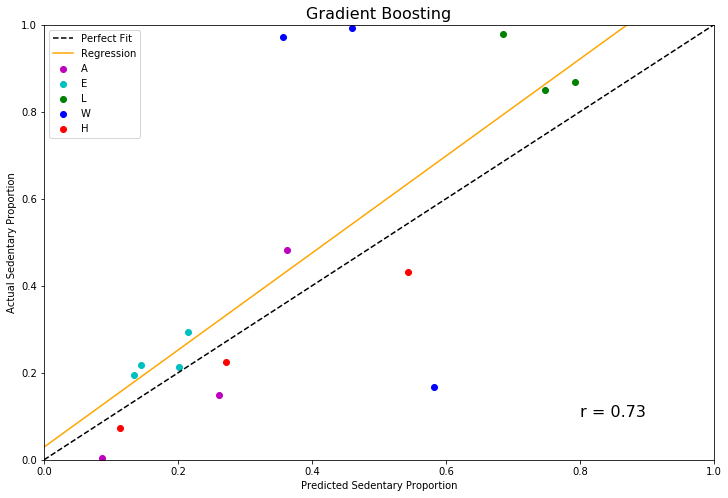

In [157]:
from matplotlib.legend import Legend
import matplotlib.axes as ax
from scipy.stats import linregress

x = np.arange(2)
y1 = x
reg = linregress(person_data_gradboost['Pred_sed_pct'],person_data_gradboost['Actual_sed_pct'])
y2 = reg[0]*x + reg[1]
colors = np.array(['b','b','b','g','g','g','r','r','r','c','c','c','c','m','m','m'])

a = person_data_gradboost[person_data_gradboost['category'] == 'A']
e = person_data_gradboost[person_data_gradboost['category'] == 'E']
l = person_data_gradboost[person_data_gradboost['category'] == 'L']
w = person_data_gradboost[person_data_gradboost['category'] == 'W']
h = person_data_gradboost[person_data_gradboost['category'] == 'H']

plt.figure(figsize = (12,8))
plt.plot(x,y1,'--',color = 'black')
plt.plot(x,y2,'-',color = 'orange')
plt.scatter(a['Pred_sed_pct'],a['Actual_sed_pct'],color = 'm')
plt.scatter(e['Pred_sed_pct'],e['Actual_sed_pct'],color = 'c')
plt.scatter(l['Pred_sed_pct'],l['Actual_sed_pct'],color = 'g')
plt.scatter(w['Pred_sed_pct'],w['Actual_sed_pct'],color = 'b')
plt.scatter(h['Pred_sed_pct'],h['Actual_sed_pct'],color = 'r')
plt.xlabel('Predicted Sedentary Proportion')
plt.ylabel('Actual Sedentary Proportion')
plt.title("Gradient Boosting",fontsize = 16)
plt.legend(['Perfect Fit','Regression','A','E','L','W','H'])
plt.xlim([0,1])
plt.ylim([0,1])
plt.text(x = 0.8, y = 0.1,s = ("r = " + str(round(reg[2],2))),fontsize = 16)

plt.show()

### Trying the Leave-one-out Cross Validation for the Neural Net

In [162]:
person_data_nn = pd.DataFrame(columns = ['id','category','actual_sed','pred_sed','total'])

for person in np.unique(data['type']):
    ## split training and testing by one person
    train = data[data['type'] != person]
    test = data[data['type'] == person]
    
    ## subset x and y variables
    train_x = train[x_vars]
    train_y = train[y_var]
    test_x = test[x_vars]
    test_y = test[y_var]
    
    ## fit model
    nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(1000, 500, 250, 125), 
                      random_state=1, verbose = True)
    nn.fit(train_x,train_y)
    
    ## predict values
    pred = nn.predict(test_x)
    
    ## output values
    print (person)
    person_data_nn.loc[len(person_data_nn)] = [person,person[:1],np.sum(test_y == 'sedentary'),np.sum(pred == 'sedentary'),len(test_y)]

person_data_nn['Pred_sed_pct'] = (person_data_nn['pred_sed'] / person_data_nn['total']).astype(float)
person_data_nn['Actual_sed_pct'] = (person_data_nn['actual_sed'] / person_data_nn['total']).astype(float)

A-4


KeyboardInterrupt: 

In [165]:
person_data_nn,person_data_gradboost

(    id category actual_sed pred_sed total
 0  A-4        A       1074     2026  7202,
       id category actual_sed pred_sed total  Pred_sed_pct  Actual_sed_pct
 0    A-4        A       1074     1878  7202      0.260761        0.149125
 1    A-6        A         29      626  7242      0.086440        0.004004
 2    A-8        A       3430     2576  7102      0.362715        0.482963
 3   E-14        E       1533     1446  7201      0.200805        0.212887
 4    E-6        E       1410      972  7241      0.134236        0.194724
 5    E-7        E       2087     1528  7107      0.214999        0.293654
 6    E-8        E       1591     1062  7300      0.145479        0.217945
 7    H-1        H       3071     3873  7117      0.544190        0.431502
 8    H-3        H       1607     1942  7139      0.272027        0.225102
 9    H-7        H        526      801  7111      0.112642        0.073970
 10   L-1        L       7160     5016  7321      0.685152        0.978008
 11   L-3    

In [ ]:
x = np.arange(2)
y1 = x
reg = linregress(person_data_nn['Pred_sed_pct'],person_data_nn['Actual_sed_pct'])
y2 = reg[0]*x + reg[1]
colors = np.array(['b','b','b','g','g','g','r','r','r','c','c','c','c','m','m','m'])

a = person_data_nn[person_data_nn['category'] == 'A']
e = person_data_nn[person_data_nn['category'] == 'E']
l = person_data_nn[person_data_nn['category'] == 'L']
w = person_data_nn[person_data_nn['category'] == 'W']
h = person_data_nn[person_data_nn['category'] == 'H']

plt.figure(figsize = (12,8))
plt.plot(x,y1,'--',color = 'black')
plt.plot(x,y2,'-',color = 'orange')
plt.scatter(a['Pred_sed_pct'],a['Actual_sed_pct'],color = 'm')
plt.scatter(e['Pred_sed_pct'],e['Actual_sed_pct'],color = 'c')
plt.scatter(l['Pred_sed_pct'],l['Actual_sed_pct'],color = 'g')
plt.scatter(w['Pred_sed_pct'],w['Actual_sed_pct'],color = 'b')
plt.scatter(h['Pred_sed_pct'],h['Actual_sed_pct'],color = 'r')
plt.xlabel('Predicted Sedentary Proportion')
plt.ylabel('Actual Sedentary Proportion')
plt.title("Neural Network",fontsize = 16)
plt.legend(['Perfect Fit','Regression','A','E','L','W','H'])
plt.xlim([0,1])
plt.ylim([0,1])
plt.text(x = 0.8, y = 0.1,s = ("r = " + str(round(reg[2],2))),fontsize = 16)

plt.show()

## Random Split of Training and Testing Set

In [ ]:
# copy = data[['mean.vm','sd.vm','mean.ang','sd.ang','p625','dfreq','ratio.df']].copy(deep=True)
# copy.loc[-1] = copy.loc[0]  # adding a row
# copy.index = copy.index + 1  # shifting index
# copy.sort_index(inplace=True)
# copy.columns = 'last.' + copy.columns
# data = pd.concat([data, copy], axis = 1)
# data = data.drop(data.index[len(data)-1])
data = sc.get_lags(data, 1)

In [ ]:
trainX, trainY, testX, testY = sc.get_test_train(data,1)

In [9]:
dataH = data[data['type'].str.contains("H")]
dataE = data[data['type'].str.contains("E")]
dataL = data[data['type'].str.contains("L")]
dataA = data[data['type'].str.contains("A")]
dataW = data[data['type'].str.contains("W")]

In [10]:
trainXH, trainYH, testXH, testYH = sc.get_test_train(dataH, 0)
trainXE, trainYE, testXE, testYE = sc.get_test_train(dataE, 0)
trainXL, trainYL, testXL, testYL = sc.get_test_train(dataL, 0)
trainXA, trainYA, testXA, testYA = sc.get_test_train(dataA, 0)
trainXW, trainYW, testXW, testYW = sc.get_test_train(dataW, 0)

## Angle Cut Point Method

In [25]:
## create the cut point
def cut_point_classify(angle):
    if angle > -15 and angle < 15:
        return 'sedentary'
    else:
        return 'non-sedentary'

In [67]:
## use the cut point
pred = data['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(pred == data['coding'])

0.51798949632894087

In [71]:
## use the cut point
predH = dataH['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(predH == dataH['coding'])

0.74814402375649591

In [72]:
## use the cut point
predE = dataE['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(predE == dataE['coding'])

0.61997719655875339

In [74]:
## use the cut point
predL = dataL['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(predL == dataL['coding'])

0.2467454528667713

In [73]:
## use the cut point
predA = dataA['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(predA == dataA['coding'])

0.61755601755601752

In [75]:
## use the cut point
predW = dataW['mean.ang'].apply(cut_point_classify)
## find accuracy
np.mean(predW == dataW['coding'])

0.31853438020461577

## SVM

In [9]:
clf = svm.SVC(cache_size=7000)

In [10]:
clf.fit(trainX,trainY)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
clf.score(testXH,testYH)

0.76466221232368226

In [11]:
clf.score(testXE,testYE)

0.66155334438916524

In [12]:
clf.score(testXL,testYL)

0.57034711964549478

In [13]:
clf.score(testXA,testYA)

0.81892091648189214

In [14]:
clf.score(testXW,testYW)

0.59935287400076132

In [11]:
clf.score(testX,testY)

0.7117851473679695

In [12]:
confusion_matrix(testY, clf.predict(testX))

array([[    0,   160,     0,     0,     3,    14,     0],
       [    0, 10571,     0,    89,   216,   855,     3],
       [    0,    98,     0,     2,     4,     3,     0],
       [    0,   196,     0,  1080,    64,   103,     0],
       [    0,   492,     0,   103,  1830,   322,     2],
       [    0,  1693,     0,   176,   358,  2953,    25],
       [    0,  1424,     0,     9,    94,   210,   157]], dtype=int64)

## Neural Network

In [11]:
n_net = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(1000, 500, 250, 125), 
                      random_state=1, verbose = True)
n_net.fit(trainX,trainY)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500, 250, 125), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [28]:
np.sum(n_net.predict(testXH) == testYH) / len(testXH)

0.67427616926503342

In [30]:
np.sum(n_net.predict(testXE) == testYE) / len(testXE)

0.57144831398562745

In [32]:
np.sum(n_net.predict(testXL) == testYL) / len(testXL)

0.18537666174298376

In [33]:
np.sum(n_net.predict(testXA) == testYA) / len(testXA)

0.69401330376940129

In [35]:
np.sum(n_net.predict(testXW) == testYW) / len(testXW)

0.36676817662733158

In [18]:
predictedVals = n_net.predict(testX)
n_net.score(testX,testY)
# f1_score(testY, predictedVals)

0.73638738895662781

In [21]:
conf_mat = confusion_matrix(testY,predictedVals,testY.unique())

In [37]:
f1_score(testY,predictedVals,average='weighted')

C:\Users\Hans\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.70974126423006312

In [27]:
for i in range(7):
    print (conf_mat[i][i] / np.sum(conf_mat[i]),testY.unique()[i])

0.918856356356 active
0.574349775785 sitting still
0.127197039778 sitting with upper body movement
0.737987987988 lying
0.592735933313 sitting and typing
0.0 kneeling
0.0 Private / Not Coded


In [22]:
conf_mat,testY.unique()

(array([[14687,   967,    64,    68,   198,     0,     0],
        [ 1773,  3202,    66,   161,   373,     0,     0],
        [ 1449,   305,   275,    48,    85,     0,     0],
        [  176,   123,     5,   983,    45,     0,     0],
        [  613,   648,    26,    81,  1991,     0,     0],
        [  109,     2,     1,     1,     3,     0,     0],
        [  165,    11,     0,     0,     1,     0,     0]], dtype=int64),
 array(['active', 'sitting still', 'sitting with upper body movement',
        'lying', 'sitting and typing', 'kneeling', 'Private / Not Coded'], dtype=object))

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
rf.score(testXH,testYH)

0.7548255382331106

In [18]:
rf.score(testXE,testYE)

0.66680486456605859

In [19]:
rf.score(testXL,testYL)

0.34490398818316098

In [20]:
rf.score(testXA,testYA)

0.7889874353288987

In [21]:
rf.score(testXW,testYW)

0.59326227636086792

In [14]:
rf.score(testX,testY)

0.67222961087991762

## KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [24]:
knn.score(testXH,testYH)

0.75668151447661469

In [25]:
knn.score(testXE,testYE)

0.65823659480375896

In [26]:
knn.score(testXL,testYL)

0.61983013293943867

In [27]:
knn.score(testXA,testYA)

0.81596452328159641

In [28]:
knn.score(testXW,testYW)

0.57689379520365436

In [21]:
knn.score(testX,testY)

0.72671500278862244

In [17]:
## determining the optimal k value
acc = []
for i in range(5,100,5):
    neigh = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
    neigh.fit(trainX,trainY)
    acc.append([i,neigh.score(testX,testY)])
acc = np.array(acc)

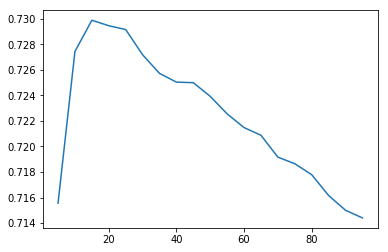

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(acc[:,0],acc[:,1])

In [31]:
conf_mat = confusion_matrix(testY, knn.predict(testX), testY.unique())

In [37]:
for i in range(7):
    print (conf_mat[i][i] / np.sum(conf_mat[i]),testY.unique()[i])

0.744634412514 sitting and typing
0.889722174876 active
0.584822286263 sitting still
0.164202745512 sitting with upper body movement
0.760221760222 lying
0.0 Private / Not Coded
0.0 kneeling


In [30]:
confusion_matrix(testY, knn.predict(testX), testY.unique()),testY.unique()

(array([[ 2047,   369,   275,    10,    48,     0,     0],
        [  303, 10440,   866,    50,    75,     0,     0],
        [  363,  1603,  3044,    58,   137,     0,     0],
        [  109,  1241,   209,   311,    24,     0,     0],
        [   92,   190,    63,     1,  1097,     0,     0],
        [    4,   162,    10,     1,     0,     0,     0],
        [    2,    97,     6,     0,     2,     0,     0]], dtype=int64),
 array(['sitting and typing', 'active', 'sitting still',
        'sitting with upper body movement', 'lying', 'Private / Not Coded',
        'kneeling'], dtype=object))

In [35]:
knn_dist = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_dist.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

In [36]:
conf_mat2 = confusion_matrix(testY, knn_dist.predict(testX), testY.unique())

In [ ]:
conf_mat2at2

In [38]:
for i in range(7):
    print (conf_mat2[i][i] / np.sum(conf_mat2[i]),testY.unique()[i])

0.748635867588 sitting and typing
0.881881711266 active
0.606916426513 sitting still
0.179514255544 sitting with upper body movement
0.767844767845 lying
0.0 Private / Not Coded
0.0 kneeling


In [39]:
knn_dist.score(testX, testY)

0.72988974215968083

In [41]:
f1_score(testY, knn_dist.predict(testX), average='weighted')

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.70753265212438199

## Boosting!

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
adaboost = AdaBoostClassifier(n_estimators=200)
adaboost.fit(trainX, trainY)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)

In [20]:
adaboost.score(testX, testY)

0.63735037968166808

In [21]:
conf_mat2 = confusion_matrix(testY, adaboost.predict(testX), testY.unique())
for i in range(7):
    print (conf_mat2[i][i] / np.sum(conf_mat2[i]),testY.unique()[i])

0.849096258932 active
0.4316982607 sitting still
0.635669673838 lying
0.560644924881 sitting and typing
0.0519693654267 sitting with upper body movement
0.00877192982456 kneeling
0.027027027027 Private / Not Coded


In [22]:
f1_score(testY, adaboost.predict(testX), average='weighted')

0.60955350678233555

In [23]:
conf_mat2

array([[10100,   957,   102,   322,   142,   243,    29],
       [ 2064,  2209,   469,   308,    53,    12,     2],
       [  267,   159,   916,    98,     0,     1,     0],
       [  426,   500,   257,  1530,    13,     3,     0],
       [ 1275,   256,    12,   168,    95,    20,     2],
       [  107,     1,     2,     3,     0,     1,     0],
       [  153,    18,     0,     4,     1,     4,     5]], dtype=int64)

## Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(n_estimators = 200,max_depth = 7)

In [26]:
grad_boost.fit(trainX, trainY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [27]:
conf_mat2 = confusion_matrix(testY, grad_boost.predict(testX), testY.unique())
for i in range(7):
    print (conf_mat2[i][i] / np.sum(conf_mat2[i]),testY.unique()[i])

0.917108028583 active
0.675004885675 sitting still
0.834836918806 lying
0.78930010993 sitting and typing
0.310175054705 sitting with upper body movement
0.0 kneeling
0.00540540540541 Private / Not Coded


In [29]:
f1_score(testY, grad_boost.predict(testX), average='weighted')

0.76959799300646581

In [30]:
conf_mat2

array([[10909,   659,    37,   118,   148,    12,    12],
       [ 1326,  3454,    52,   169,   111,     2,     3],
       [  123,    89,  1203,    21,     2,     3,     0],
       [  284,   245,    27,  2154,    18,     0,     1],
       [ 1027,   181,     8,    43,   567,     2,     0],
       [  106,     5,     1,     1,     1,     0,     0],
       [  168,    13,     0,     1,     2,     0,     1]], dtype=int64)